<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Using Pipeline with Alphalens

Once you have a pipeline, there are two main things you can do with it:

1. Feed the pipeline results to Alphalens to analyze whether your factors are predictive of forward returns;
2. Use the pipeline in a Zipline strategy for the purpose of universe selection and/or trading signal generation. 

Analyzing your pipeline output with Alphalens makes sense if your pipeline includes factors that might be predictive of forward returns; it doesn't make sense if you are only using your pipeline for universe selection.

In this notebook, we will create a pipeline with a moving average factor for the `TradableStocksUS` universe, then use Alphalens to analyze whether the factor is predictive.

In [1]:
from zipline.pipeline import Pipeline
from zipline.research import run_pipeline
from zipline.pipeline.data import EquityPricing, master
from zipline.pipeline.factors import SimpleMovingAverage
# import our TradableStocksUS function
from codeload.pipeline_tutorial.tradable_stocks import TradableStocksUS

Let's create a factor that measures the percent difference between the 10-day and 30-day moving averages (close price). In other words, we are computing the degree to which the 10-day moving average is above the 30-day moving average.

As an added benefit, we will include each stock's sector in our pipeline output, which will allow use to view some additional Alphalens plots breaking down the factor's performance by sector.

In [2]:
def make_pipeline():
    
    universe = TradableStocksUS()
    
    # 10-day close price average.
    mean_10 = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=10, mask=universe)

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=30, mask=universe)

    # Percent difference factor.
    percent_difference = (mean_10 - mean_30) / mean_30
        
    return Pipeline(
        columns={
            'percent_difference': percent_difference,
            'sector': master.SecuritiesMaster.usstock_Sector.latest
        },
        screen=universe
    )

Running this pipeline will result in a DataFrame containing 2 columns, `percent_difference`, our predictive factor, and `sector`.

In [3]:
factors = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2016-01-01')
factors.head()

percent_difference  \
2015-01-02 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])              -0.003377   
                          Equity(FIBBG005P7Q881 [AAL])             0.053626   
                          Equity(FIBBG003PNL136 [AAMC])           -0.162339   
                          Equity(FIBBG000D9V7T4 [AAN])             0.043003   
                          Equity(FIBBG000D6VW15 [AAOI])           -0.004641   

                                                              sector  
2015-01-02 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])      Technology  
                          Equity(FIBBG005P7Q881 [AAL])   Industrials  
                          Equity(FIBBG003PNL136 [AAMC])   Financials  
                          Equity(FIBBG000D9V7T4 [AAN])   Industrials  
                          Equity(FIBBG000D6VW15 [AAOI])   Technology

To see if our factor is predictive of forward returns, we use the factor data to request forward returns for the assets and dates in our pipeline output. In this example we request returns for the next day, next week (5 trading days), and next month (approx. 21 trading days).

In [4]:
from zipline.research import get_forward_returns

# Get forward returns for the next day, next week, and next month
forward_returns = get_forward_returns(factors, periods=[1,5,21])

Then, we format the factor and returns data for use with Alphalens, passing in our sectors as the grouping key (grouping is optional):

In [5]:
import alphalens as al

al_data = al.utils.get_clean_factor(
    factors["percent_difference"], 
    forward_returns, 
    groupby=factors['sector']
)

Dropped 8.7% entries from factor data: 8.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Finally, we create the Alphalens tear sheet. 

In this example, the "Mean Period Wise Return By Factor Quantile" plot reveals that forward returns increase from quantiles 1 to 4, but then drop off in quantile 5. Intuitively, this tells us that stocks tend to perform better when their 10-day moving average is above their 30-day moving average, up to a point. But if the 10-day moving average gets too far stretched above the 30-day moving average, the forward returns are poor.

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.679635,0.000720,-0.063912,0.048896,100677,20.018731
2,-0.072488,0.021709,-0.017221,0.015982,100535,19.990495
3,-0.051018,0.037782,-0.000005,0.014459,100537,19.990893
4,-0.035756,0.058825,0.016335,0.014920,100535,19.990495
5,-0.018567,1.518380,0.057822,0.048915,100630,20.009385


Returns Analysis


,1D,21D,5D
Ann. alpha,-0.035,-0.033,-0.033
beta,-0.145,-0.305,-0.189
Mean Period Wise Return Top Quantile (bps),-2.190,-1.322,-2.084
Mean Period Wise Return Bottom Quantile (bps),-0.279,-1.610,-0.978
Mean Period Wise Spread (bps),-1.911,0.369,-1.041


<Figure size 1152x432 with 0 Axes>

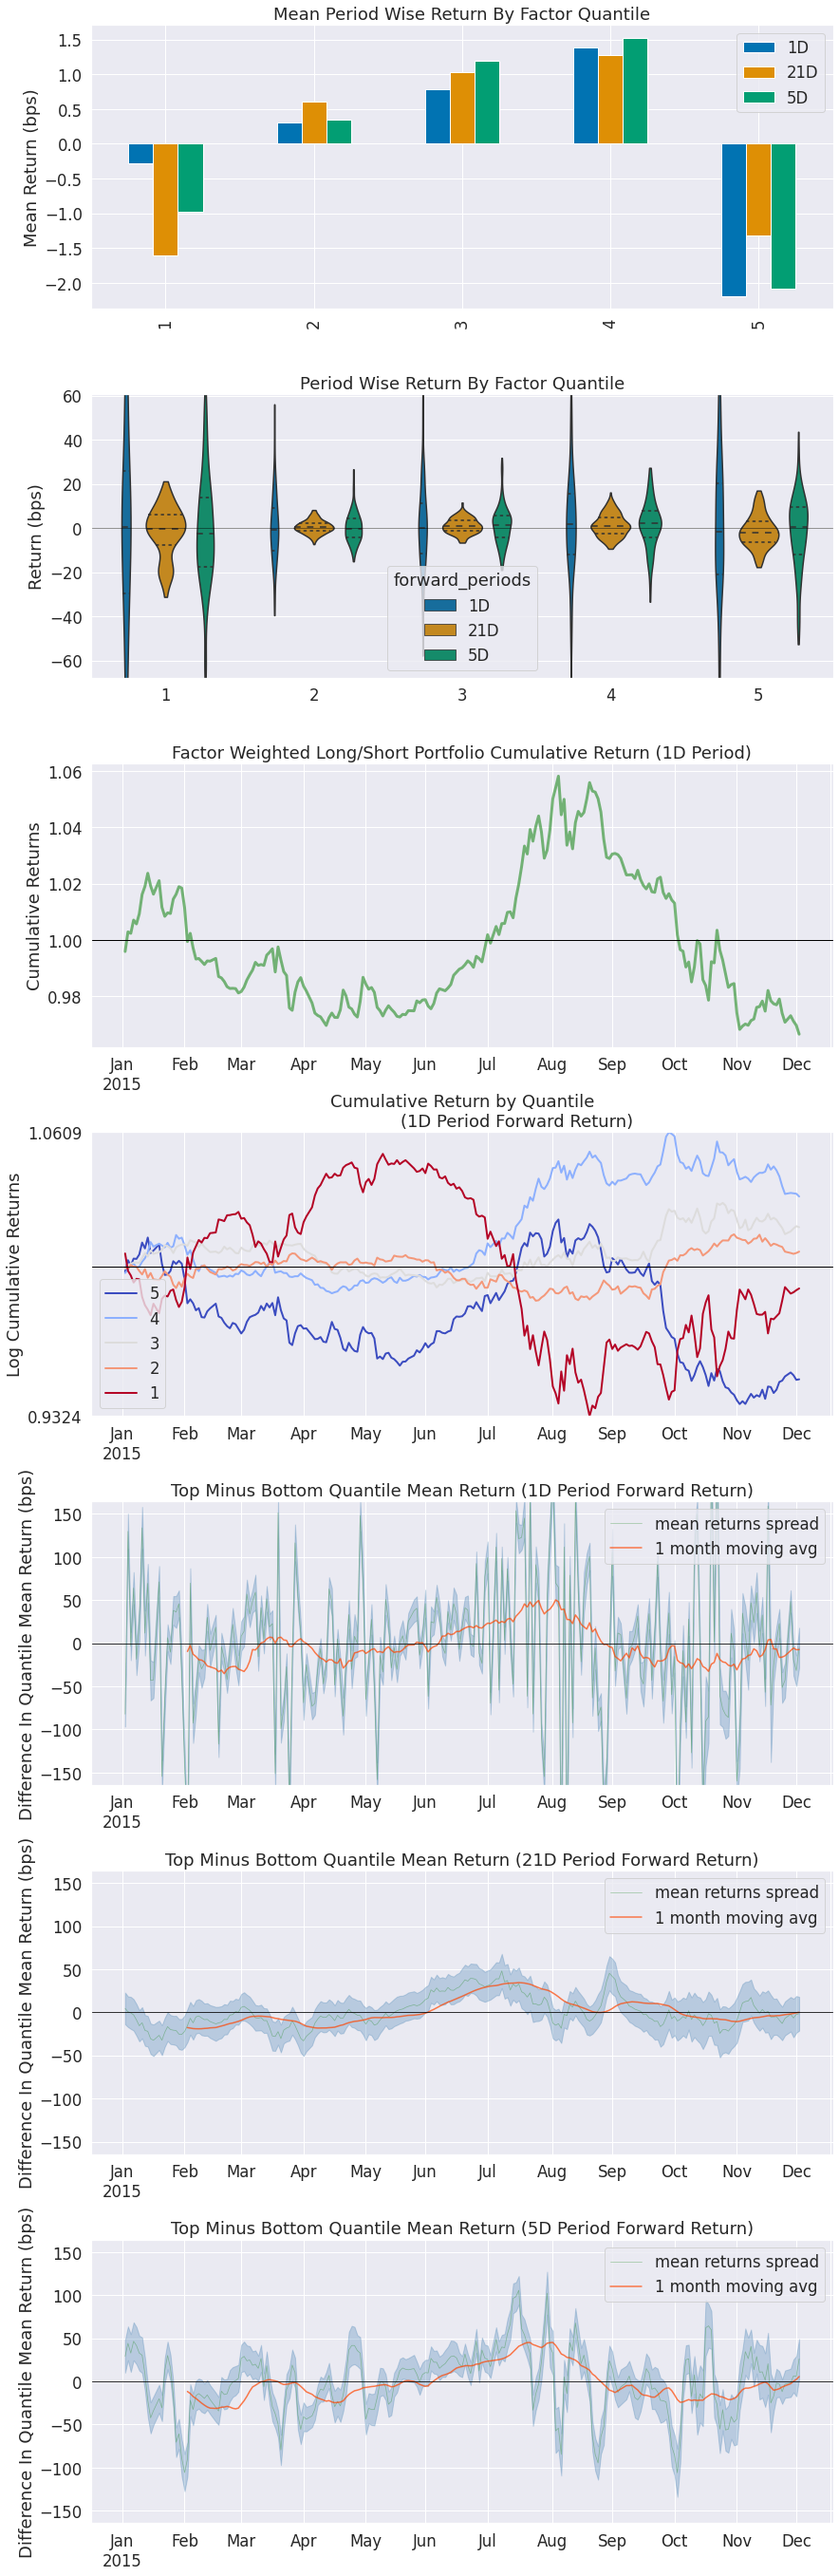

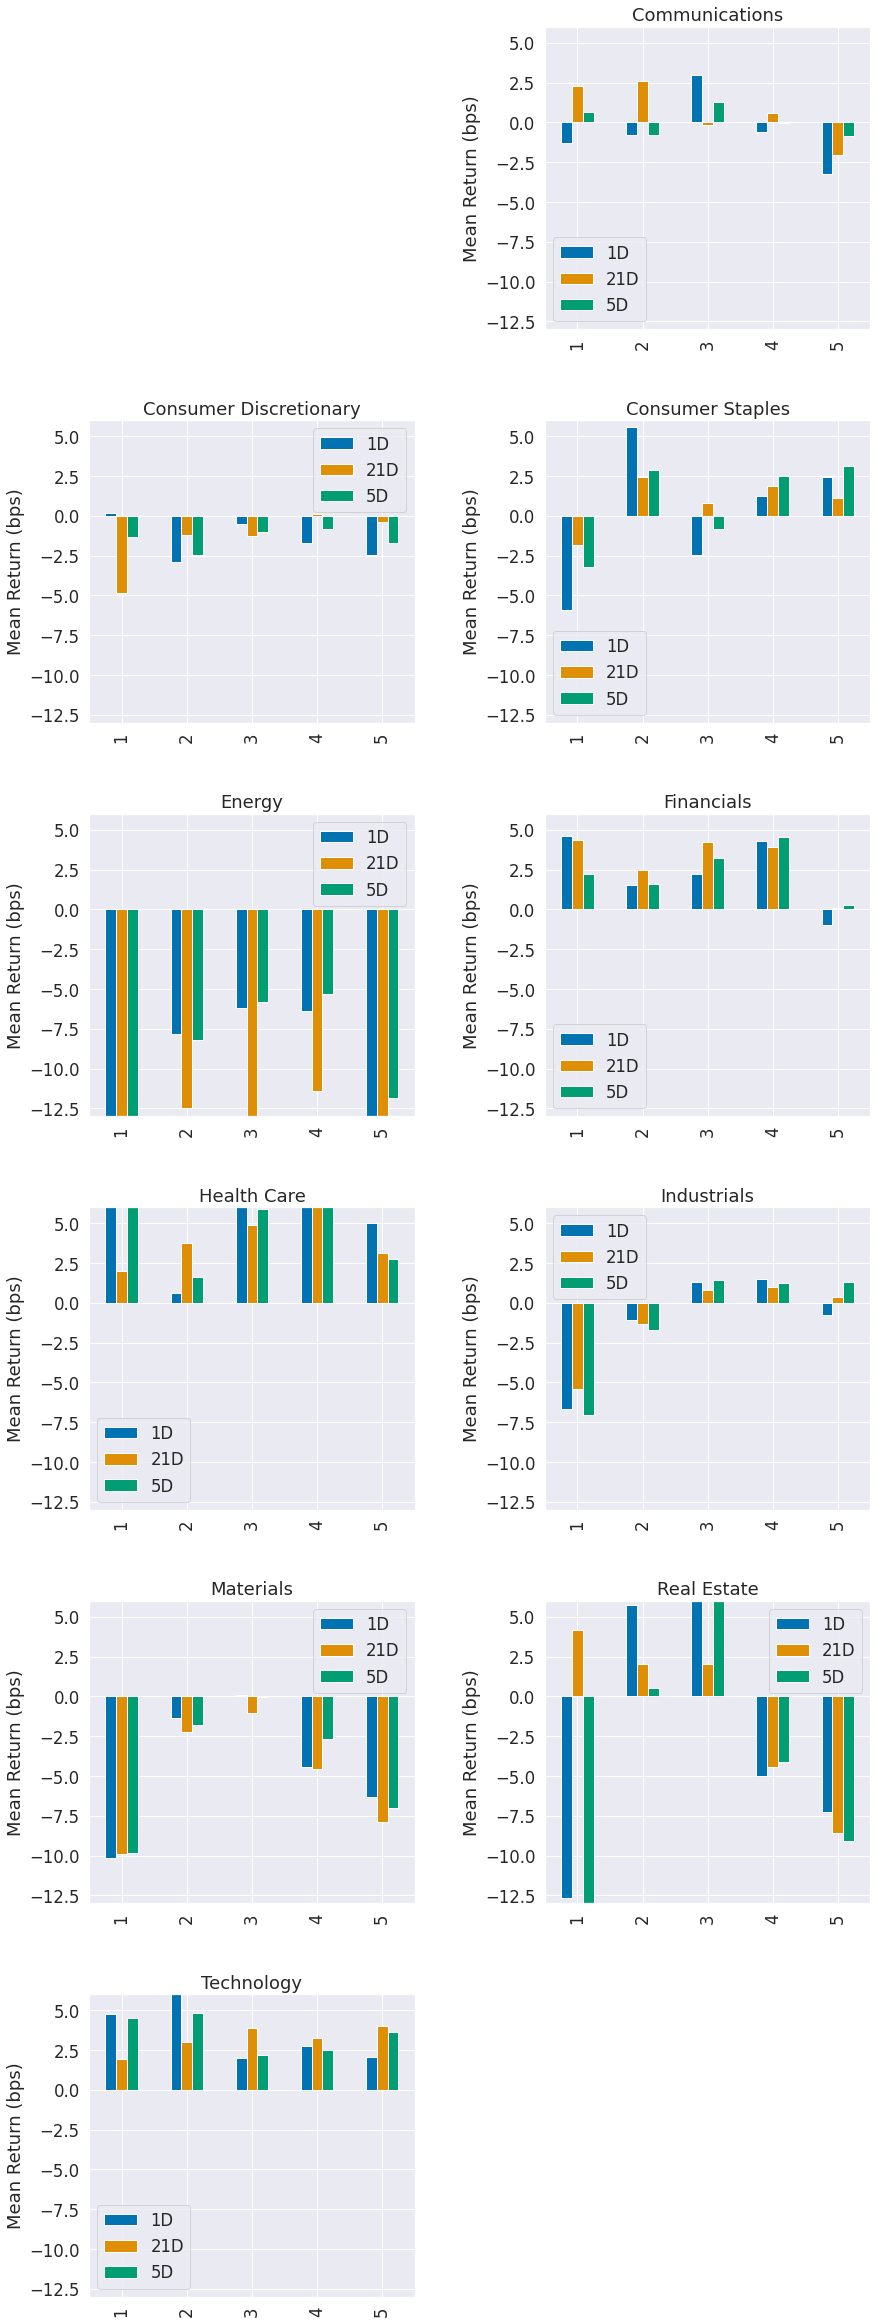

Information Analysis


,1D,21D,5D
IC Mean,0.005,0.001,0.004
IC Std.,0.129,0.125,0.129
Risk-Adjusted IC,0.037,0.011,0.034
t-stat(IC),0.558,0.167,0.524
p-value(IC),0.578,0.867,0.601
IC Skew,-0.023,0.442,-0.123
IC Kurtosis,0.130,-0.474,-0.026


/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

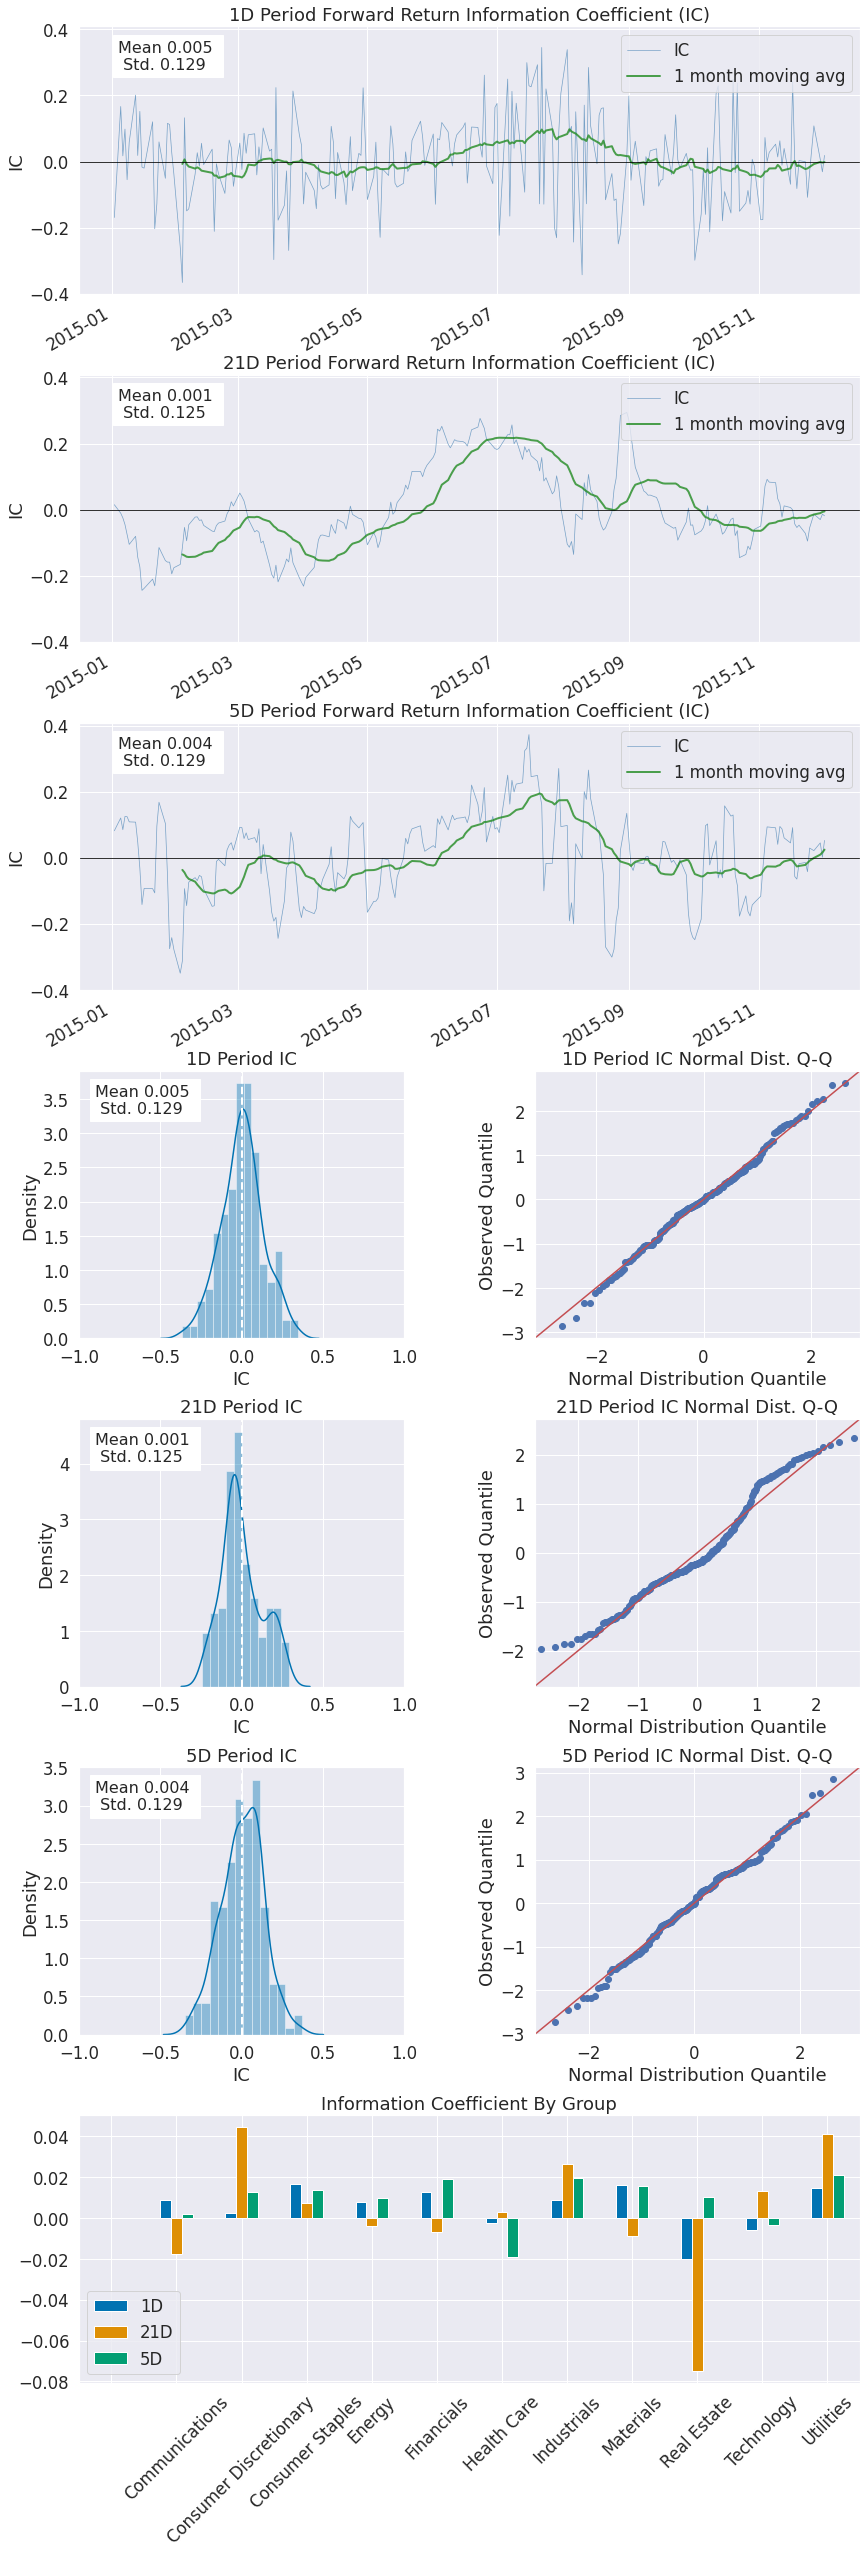

/opt/conda/envs/zipline/lib/python3.6/site-packages/alphalens/utils.py:920: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,1D,5D,21D
Quantile 1 Mean Turnover,0.064,0.283,0.721
Quantile 2 Mean Turnover,0.153,0.531,0.782
Quantile 3 Mean Turnover,0.182,0.580,0.775
Quantile 4 Mean Turnover,0.159,0.543,0.773
Quantile 5 Mean Turnover,0.068,0.306,0.771


,1D,21D,5D
Mean Factor Rank Autocorrelation,0.99,0.062,0.82


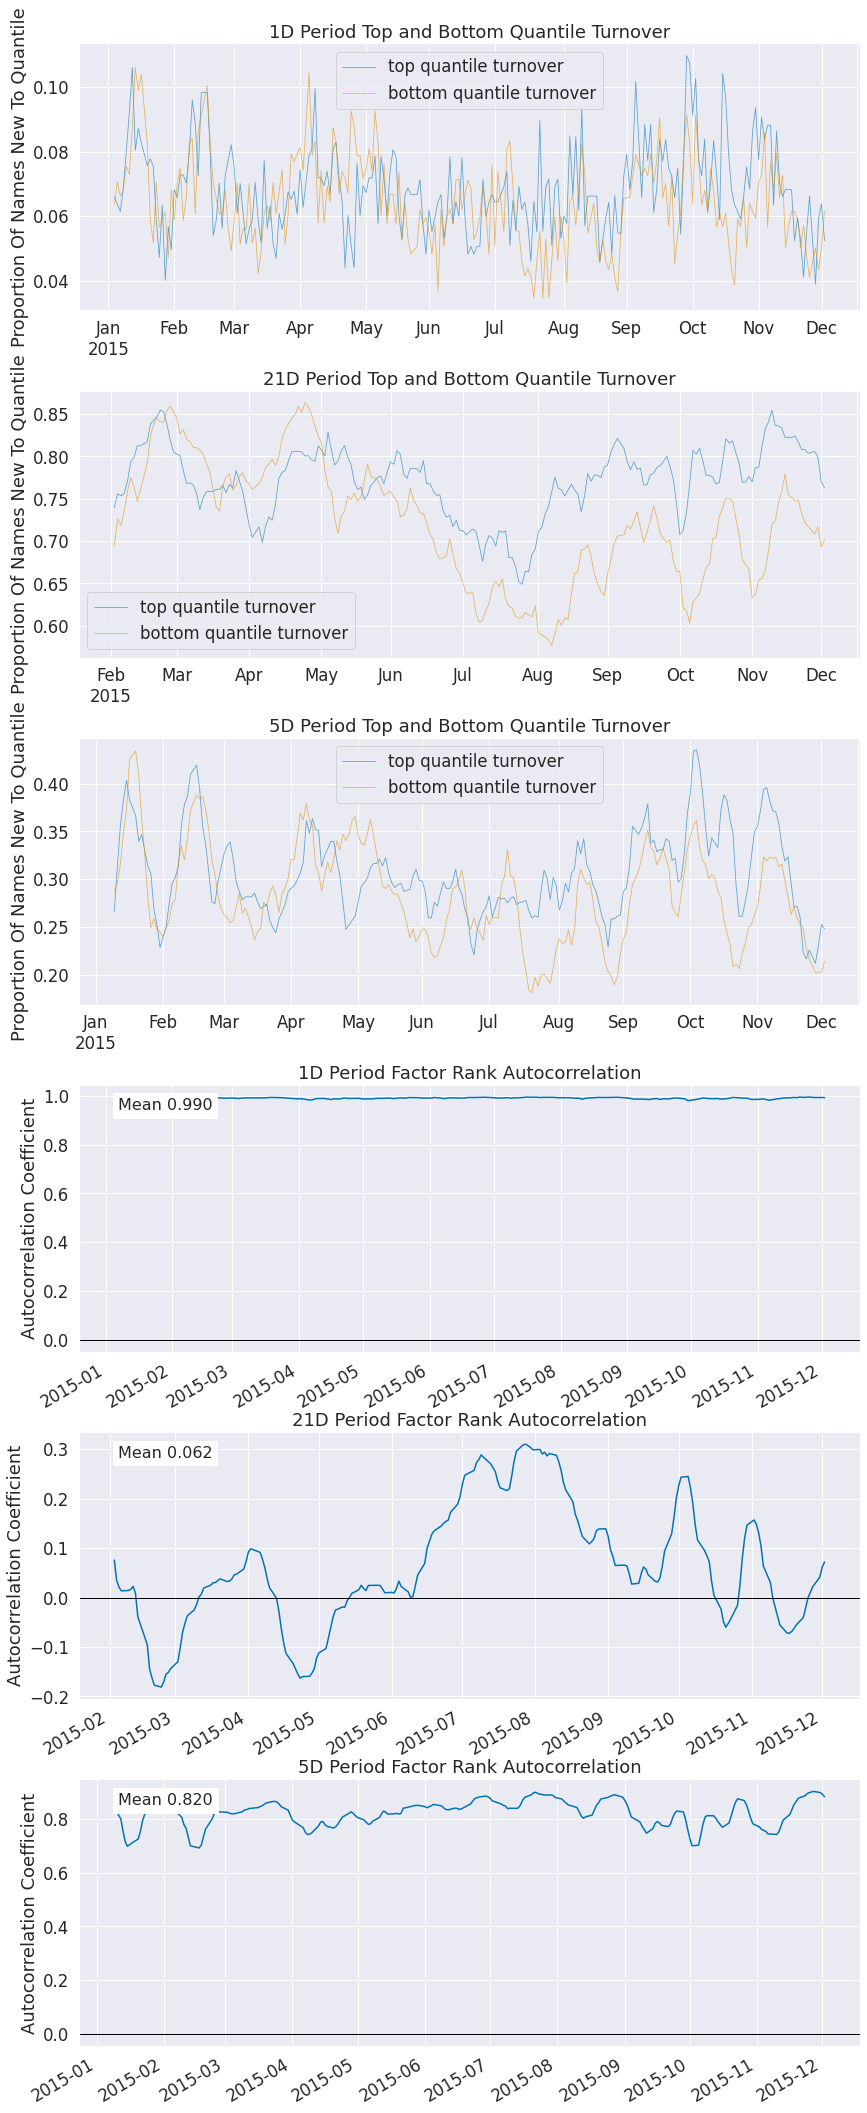

In [6]:
from alphalens.tears import create_full_tear_sheet
create_full_tear_sheet(al_data, by_group=True)

For more information on interpreting an Alphalens tear sheet, please see Lecture 38 of the [Quant Finance Lecture series](https://www.quantrocket.com/code/?repo=quant-finance-lectures) in the Code Library.

---
[Back to Introduction](Introduction.ipynb) 